---

# Curso: Data Mining - Semana 14
# Sistemas de Recomendación basado en Contenido


Docente: Soledad Espezúa (s.espezual@up.edu.pe)

---


En este enfoque se analizan los perfiles de los usuarios o ítems basados en la naturaleza de sus atributos o características.
Los sistemas basados en contenido crean perfiles para descubrir cuáles son los aspectos favoritos de un usuario o de un ítem, y luego hacen recomendaciones sobre elementos que comparten esos aspectos. En este enfoque se recomienda un ítem a un usuario en función de las acciones pasadas del usuario hacia un tipo de ítem similar. Aquí la similitud se mide por el contenido de los ítems.  

En este cuadernillo, mostraremos los sistemas de recomendación basados en contenido e implementaremos una versión simple de uno usando Python y Pandas.


<a id="ref1"></a>

# Acerca de los datos

Este cuaderno usa la data de MovieLens completa, la cual contiene informacion de 34208 movies y 22884377 calificaciones (ratings de hasta 5 estrellas) generadas por usuarios.


https://grouplens.org/datasets/movielens/.

<hr>

<a id="ref2"></a>

# Pre-procesamiento


In [1]:
# Importa librerias
import pandas as pd
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt


Lee los archivos de datos:


In [2]:
# Lee la informacion de movies a un  pandas dataframe
movies = pd.read_csv('movies_small.csv')
# lee la informacion de ratings de usuarios e un pandas dataframe
ratings = pd.read_csv('ratings_small.csv')

In [3]:
movies_df = movies.copy()
ratings_df = ratings.copy()

movies_df.head() # muestra cabecera de movies_df

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Cada película tiene un único ID, un título y su año de lanzamiento junto con él (puede contener caracteres Unicode) y varios géneros diferentes en el mismo campo.


Vamos extraer la informacion de año de la columna **title** y colocarla en una nueva columna  **year**. Para ello usaremos la función [extract](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.extract.html) de Pandas.


In [4]:
# Usaremos una expresion regular para extraerr el año entre parentesis y colocarla en nueva columna year
movies_df['year'] = movies_df.title.str.extract('(\(\d\d\d\d\))',expand=False)
# Remueve parentesis de columna year
movies_df['year'] = movies_df.year.str.extract('(\d\d\d\d)',expand=False)
# Remueve el año de la columna 'title'
movies_df['title'] = movies_df['title'].str.replace(r'\(\d{4}\)', '', regex=True).str.strip()
# Aplica la funcion strip para borrar cualquier caracter en blanco que haya quedado al final de title
movies_df['title'] = movies_df['title'].apply(lambda x: x.strip())
movies_df.head()

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


Ahora dividimos los valores de la columna **genres** en una lista de generos para simplificar el uso futuro. Para ello aplicamos la función split de  Python a la columna **genres**.


In [5]:
#Como cada genero se separa por |  entonces usamos split function para obtener una lista de generos
movies_df['genres'] = movies_df.genres.str.split('|')
movies_df.head()

,movieId,title,genres,year
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995
2,3,Grumpier Old Men,"[Comedy, Romance]",1995
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995
4,5,Father of the Bride Part II,[Comedy],1995


Ahora vamos a convertir la listas de la columna **genres** en varias columnas usando la tecnica **One Hot Encoding**, donde cada columna corresponderá a un genero pudiendo tener dos valores: valor 1 indica que el movie es de ese genero y valor 0 indica que no lo es

In [ ]:
'''
# Copia el dataframe de movies en un nuevo dataframe pra hacer el one hot encoding.
moviesWithGenres_df = movies_df.copy()

#Por cada fila del dataframe itera la lista de genres colocando  1 en la columna correspondiente
for index, row in movies_df.iterrows():
  for genre in row['genres']:
    moviesWithGenres_df.at[index, genre] = 1

# Reemplaza los NaNs los reemplaza con 0
moviesWithGenres_df = moviesWithGenres_df.fillna(0)
moviesWithGenres_df.head()
'''

In [65]:
# Copia el dataframe de movies en un nuevo dataframe para hacer el one hot encoding.
moviesWithGenres_df = movies_df.copy()

# Realiza el One-Hot Encoding para la columna de géneros
moviesWithGenres_df = moviesWithGenres_df.explode('genres')
#moviesWithGenres_df = pd.get_dummies(moviesWithGenres_df, columns=['genres'])
moviesWithGenres_df = pd.get_dummies(moviesWithGenres_df, columns=['genres'], prefix='', prefix_sep='')


# Agrupa por 'movieId' y usa el máximo para combinar las filas resultantes de 'explode'
moviesWithGenres_df = moviesWithGenres_df.groupby(['movieId', 'title']).max().reset_index()

# Reemplaza los NaNs con 0 antes de convertir a enteros
moviesWithGenres_df = moviesWithGenres_df.fillna(0)

# Identifica las columnas de géneros para asegurarse de que no se incluyan las columnas movieId y title en la conversión
genre_columns = moviesWithGenres_df.columns.difference(['movieId', 'title'])

# Convierte solo las columnas de géneros a enteros
moviesWithGenres_df[genre_columns] = moviesWithGenres_df[genre_columns].astype(int)

# Muestra las primeras filas del dataframe resultante
moviesWithGenres_df.head()

,movieId,title,year,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story,1995,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji,1995,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men,1995,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale,1995,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II,1995,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [66]:
moviesWithGenres_df.shape

(9742, 23)

In [67]:
# veamos datos de ratings
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [19]:
ratings_df.shape

(100836, 4)

Cada fila del dataframe ratings tiene un  userId asociado con al menos un movie, un rating y un timestamp. No necesitaremos del timestamp, asi que lo eliminamos para liberar memoria.


In [68]:
#Eliminamos timestamp para  ahorrar memoria
ratings_df = ratings_df.drop('timestamp', axis=1)
ratings_df.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


<hr>

<a id="ref3"></a>

# Sistema de Recomendacion basado en Filtrado por Contenido de Items


Vamos implementar un sistema de recomendación basado  en contenido (también llamado **Sistema de recomendación item-item**). Esta técnica busca descubrir los atributos favoritos de los item para un usuario y luego recomienda nuevos items que presenten esos atributos. Para el presente caso de recomendación de peliculas, los atributos de los items son los géneros favoritos de las peliculas que ya vió el usuario de entrada  y las respectivas calificaciones otorgadas.

Comenzamos creando un usuario de entrada para recomendar peliculas similares a estas:



```
Nota: Cuando agregue mas movies tenga cuidado al escribir iniciando con letra mayúscula y si la pelicula inicia
con "The", como  "The Harder They Fall"  escribir como : 'Harder They Fall, The'.
```



In [69]:
# Introduciendo un usuario de consulta
# necesita introducir algunas peliculas y un rating de preferencia
userInput = [
            {'title':'American President, The', 'rating':5},
            {'title':'Toy Story', 'rating':3.5},
            {'title':'Jumanji', 'rating':2},
            {'title':"Casino", 'rating':5},
            {'title':"Forrest Gump", 'rating':5},
            {'title':'Jurassic Park', 'rating':4.5}
         ]
inputMovies = pd.DataFrame(userInput)
inputMovies

,title,rating
0,"American President, The",5.0
1,Toy Story,3.5
2,Jumanji,2.0
3,Casino,5.0
4,Forrest Gump,5.0
5,Jurassic Park,4.5


#### Colocamos el movieId a cada item del usuario de entrada

Ahora se extrae y adicionan los ID de movies dataframe y también eliminamos columnas innecesarias para ahorrar memoria.

In [70]:
# Realiza un merge directo para obtener los registros (movies) del usuario de consulta basado en el título del movie
mergedMovies = pd.merge(movies_df, inputMovies, on='title', suffixes=('', '_drop'))

# Elimina las columnas 'genres', 'year' y cualquier columna duplicada con sufijo '_drop'
columns_to_drop = ['genres', 'year']
columns_to_drop += [col for col in mergedMovies.columns if col.endswith('_drop')]

# Elimina las columnas innecesarias
inputMovies = mergedMovies.drop(columns=columns_to_drop)

inputMovies

,movieId,title,rating
0,1,Toy Story,3.5
1,2,Jumanji,2.0
2,11,"American President, The",5.0
3,16,Casino,5.0
4,356,Forrest Gump,5.0
5,480,Jurassic Park,4.5


In [ ]:
'''
# Recuperamos  del dataframe  movies_df los registros (movies) del usuario de consulta. La busqueda es por el title del movie
inputId = movies_df[movies_df['title'].isin(inputMovies['title'].tolist())]
# Junta el resultado de la busqueda con el dataframe de la consulta de usuario (inputMovies)
inputMovies = pd.merge(inputId, inputMovies)
# Elimina columna genres y columna año  que no vamos a necesitar para liberar memoria
inputMovies = inputMovies.drop('genres', axis=1).drop('year', axis=1)
inputMovies
'''

#### Recuperamos los movies que el usuario ha visto, pero con la info de generos

Aqui vamos aprender sobre las preferencias del usuario de entrada. Para ello vamos a recuperar el subconjunto de movies que el usuario ha visto del dataframe **moviesWithGenres_df**, el cual contiene informacion de generos en forma one-hot encoding


In [71]:
# Realiza un merge directo para obtener los registros de moviesWithGenres_df relativos a las películas que el usuario ha visto
userMovies = pd.merge(moviesWithGenres_df, inputMovies[['movieId']], on='movieId')
userMovies

,movieId,title,year,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story,1995,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji,1995,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,11,"American President, The",1995,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,16,Casino,1995,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,356,Forrest Gump,1994,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0
5,480,Jurassic Park,1993,0,1,1,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0


In [ ]:
# Recupera los registros de moviesWithGenres_df relativo a los movies que el usuario ha visto
#userMovies = moviesWithGenres_df[moviesWithGenres_df['movieId'].isin(inputMovies['movieId'].tolist())]

Solo necesitamos la tabla de generos, asi que eliminamos todas las otras columnas.


In [72]:
# Reseatmos el indice del dataframe para evitar algun problema posterior
userMovies = userMovies.reset_index(drop=True)

# Borramos todas las columnas que no sean de los géneros para liberar memoria
columns_to_drop = ['movieId', 'title','year']
userGenreTable = userMovies.drop(columns=columns_to_drop)

userGenreTable

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0
5,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0


#### Obtiene el User Profile del usuario de entrada

Vamos a obtener ahora el user profile, esto es, los pesos que el usuario dá a los generos de las peliculas. Para eso se va multiplicar cada vector one-hot de generos de las peliculas del usurio por las calificaciones que él le dió. Esta operacion se puede hacer como el producto punto entre la matriz one-hot de generos por el vector de ratings  


In [73]:
# ratings de los movies del usuario de entrada
inputMovies['rating']

0    3.5
1    2.0
2    5.0
3    5.0
4    5.0
5    4.5
Name: rating, dtype: float64

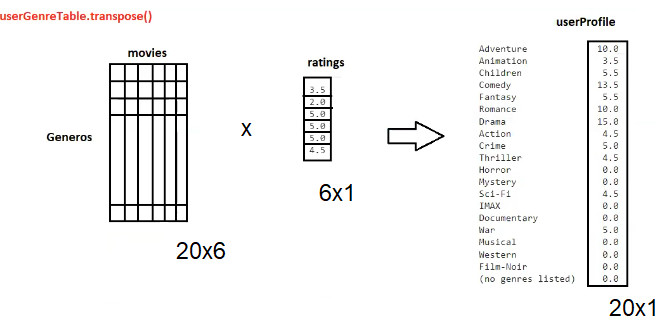

In [74]:
# Obtiene el userProfile haciendo Producto punto de tabla de generos x ratings
userProfile = userGenreTable.transpose().dot(inputMovies['rating'])
userProfile

(no genres listed)     0.0
Action                 4.5
Adventure             10.0
Animation              3.5
Children               5.5
Comedy                13.5
Crime                  5.0
Documentary            0.0
Drama                 15.0
Fantasy                5.5
Film-Noir              0.0
Horror                 0.0
IMAX                   0.0
Musical                0.0
Mystery                0.0
Romance               10.0
Sci-Fi                 4.5
Thriller               4.5
War                    5.0
Western                0.0
dtype: float64

#### Ahora construimos la recomendacion final

Con el userProfile podemos construir la recomendacion, es decir, la lista de  movies que satisfaga las preferencias de usuario.


Comenzamos extrayendo la tabla one-hot de movies con generos del dataframe moviesWithGenres_df:

In [79]:
# Obtiene tabla de movies con generos (one hot)  del dataframe moviesWithGenres_df
genreTable = moviesWithGenres_df.set_index(moviesWithGenres_df['movieId']) # indexa con movieId

# Borramos todas las columnas que no sean de los géneros para liberar memoria
columns_to_drop = ['movieId', 'title','year']
genreTable = genreTable.drop(columns=columns_to_drop)
genreTable.head()

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,,
1,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [80]:
genreTable.shape

(9742, 20)

La lista de movies a recomendar se genera haciendo un promedio ponderado de cada movie por el userProfile y luego se ordena esa lista ponderada de mayor a menor. Los movies con valores más altos son los que más probablemente satisfagan al usuario  


In [81]:
# Obtiene la lista de recomendacion multiplicando la tabla de movies con generos (genreTable) con el userProfile
recommendationTable_df = ((genreTable*userProfile).sum(axis=1))/(userProfile.sum())
recommendationTable_df.head()

movieId
1    0.439306
2    0.242775
3    0.271676
4    0.445087
5    0.156069
dtype: float64

In [82]:
# Ordena la lista de recomendacion ponderada en orden decreciente
recommendationTable_df = recommendationTable_df.sort_values(ascending=False)
recommendationTable_df.head()

movieId
26236     0.670520
108540    0.664740
1907      0.664740
4956      0.664740
4719      0.647399
dtype: float64

Ahora muestra los top 10 movies a recomendar


In [83]:
# La tabla de top 10 movies a recomendar
movies_df.loc[movies_df['movieId'].isin(recommendationTable_df.head(10).keys())]

,movieId,title,genres,year
743,970,Beat the Devil,"[Adventure, Comedy, Crime, Drama, Romance]",1953
1390,1907,Mulan,"[Adventure, Animation, Children, Comedy, Drama...",1998
3460,4719,Osmosis Jones,"[Action, Animation, Comedy, Crime, Drama, Roma...",2001
3608,4956,"Stunt Man, The","[Action, Adventure, Comedy, Drama, Romance, Th...",1980
5476,26236,"White Sun of the Desert, The (Beloe solntse pu...","[Action, Adventure, Comedy, Drama, Romance, War]",1970
6094,42015,Casanova,"[Action, Adventure, Comedy, Drama, Romance]",2005
6219,45672,Click,"[Adventure, Comedy, Drama, Fantasy, Romance]",2006
7170,71999,Aelita: The Queen of Mars (Aelita),"[Action, Adventure, Drama, Fantasy, Romance, S...",1924
8349,108540,Ernest & Célestine (Ernest et Célestine),"[Adventure, Animation, Children, Comedy, Drama...",2012
9169,148775,Wizards of Waverly Place: The Movie,"[Adventure, Children, Comedy, Drama, Fantasy, ...",2009


In [84]:
inputMovies

,movieId,title,rating
0,1,Toy Story,3.5
1,2,Jumanji,2.0
2,11,"American President, The",5.0
3,16,Casino,5.0
4,356,Forrest Gump,5.0
5,480,Jurassic Park,4.5
